In [114]:
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from vis import *

from data.make_data_directories import *

np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(12344)

In [115]:
make_directories(val_percentage=0.15 , test_percentage= 0  , glare="CARS_HERTZ_BIDS\glare" , no_glare="CARS_HERTZ_BIDS\\noglare")

In [116]:
DATA_DIR = 'data/'
sz = 420
batch_size = 128

In [117]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}val'
val_screen_dir = f'{DATA_DIR}val_screen'
test_hrtz = f'{DATA_DIR}_test_hertz'
test_bids = f'{DATA_DIR}_test_bids'

In [118]:
os.listdir(test_bids)

['glare', 'noglare']

In [119]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['data/train\\glare\\00233.jpg',
 'data/train\\glare\\00343.jpg',
 'data/train\\glare\\00495.jpg',
 'data/train\\glare\\00496.jpg',
 'data/train\\glare\\00562.jpg']

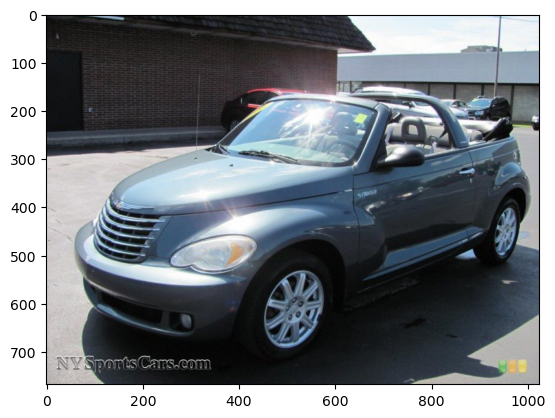

In [120]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

In [121]:
train_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomCrop((sz, sz)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(60),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=train_transforms)
valid_ds = datasets.ImageFolder(val_dir, transform=valid_transforms)
test_hrtz_ds = datasets.ImageFolder(test_hrtz, transform=valid_transforms)
test_bids_ds = datasets.ImageFolder(test_bids, transform=valid_transforms)
val_screen_ds = datasets.ImageFolder(val_screen_dir, transform=valid_transforms)

train_ds.classes

['glare', 'no_glare']

In [122]:
train_ds[0][0].shape

torch.Size([3, 420, 420])

In [123]:
train_ds.class_to_idx

{'glare': 0, 'no_glare': 1}

In [124]:
len(train_ds), len(valid_ds)

(1124, 198)

In [125]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

valid_screen_dl = torch.utils.data.DataLoader(val_screen_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)


test_bids_dl = torch.utils.data.DataLoader(test_bids_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

test_hrtz_dl = torch.utils.data.DataLoader(test_hrtz_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

In [126]:
train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 1124
Valid size: 198 (0.15)


In [127]:
inputs, targets = next(iter(train_dl))

In [128]:
targets

tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1])

In [148]:

num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights="DEFAULT")

ii=1
for param in model.parameters():
    if ii < 133:
        param.requires_grad = False
    ii+=1

    
model.classifier[1] = nn.Sequential(
    nn.Dropout(p = 0.2),nn.Linear(1280, 500), nn.ReLU(),nn.Dropout(p = 0.5) ,  nn.Linear(500, num_classes)
)

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [130]:
ii=1
for param in model.parameters():
    print(ii , param.requires_grad)
    ii+=1

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 Fals

In [131]:
# num_classes = 2
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




# # model = torchvision.models.vgg16(weights="DEFAULT")


# for param in model.parameters():
#     param.requires_grad = False

# model.avgpool = nn.Identity()
# model.classifier = nn.Sequential(
#     nn.Linear(2048, 100), nn.ReLU(),nn.Dropout(p = 0.5) ,  nn.Linear(100, num_classes)
# )
# model.to(device)

In [132]:
pytorch_total_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)

In [133]:
pytorch_total_params

2001502

In [134]:
learning_rate = 1e-3
num_epochs = 35

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




In [136]:
def check_accuracy(loader, model , mode = "train"):
    if mode == "train":
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            # print(predictions , y)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

    return float(num_correct)/float(num_samples)*100

In [137]:
train_acc = []
val_acc = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    print("EPOCH: ", epoch, "\n\n")
    losses = []


    for batch_idx, (data, targets) in enumerate(tqdm(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")
    train_acc.append(check_accuracy(train_dl, model , "train"))
    vv = check_accuracy(valid_dl, model , "val")
    val_acc.append(vv)

    if vv >= best_val_acc:
        torch.save(model.state_dict(), 'checkpoints/best_model_epoch_'+str(epoch)+'.pth')
        best_val_acc = vv
    

# Check accuracy on training & test to see how good our model





check_accuracy(train_dl, model)

EPOCH:  0 




100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Cost at epoch 0 is 0.64208
Checking accuracy on training data
Got 797 / 1124 with accuracy 70.91
Checking accuracy on test data
Got 121 / 198 with accuracy 61.11
EPOCH:  1 




100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Cost at epoch 1 is 0.48159
Checking accuracy on training data
Got 824 / 1124 with accuracy 73.31
Checking accuracy on test data
Got 121 / 198 with accuracy 61.11
EPOCH:  2 




100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Cost at epoch 2 is 0.38158
Checking accuracy on training data
Got 950 / 1124 with accuracy 84.52
Checking accuracy on test data
Got 156 / 198 with accuracy 78.79
EPOCH:  3 




100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Cost at epoch 3 is 0.29944
Checking accuracy on training data
Got 900 / 1124 with accuracy 80.07
Checking accuracy on test data
Got 140 / 198 with accuracy 70.71
EPOCH:  4 




100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Cost at epoch 4 is 0.25511
Checking accuracy on training data
Got 978 / 1124 with accuracy 87.01
Checking accuracy on test data
Got 164 / 198 with accuracy 82.83
EPOCH:  5 




100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Cost at epoch 5 is 0.22618
Checking accuracy on training data
Got 1009 / 1124 with accuracy 89.77
Checking accuracy on test data
Got 178 / 198 with accuracy 89.90
EPOCH:  6 




100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Cost at epoch 6 is 0.22239
Checking accuracy on training data
Got 987 / 1124 with accuracy 87.81
Checking accuracy on test data
Got 160 / 198 with accuracy 80.81
EPOCH:  7 




100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Cost at epoch 7 is 0.16387
Checking accuracy on training data
Got 913 / 1124 with accuracy 81.23
Checking accuracy on test data
Got 143 / 198 with accuracy 72.22
EPOCH:  8 




100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Cost at epoch 8 is 0.16055
Checking accuracy on training data
Got 1044 / 1124 with accuracy 92.88
Checking accuracy on test data
Got 165 / 198 with accuracy 83.33
EPOCH:  9 




100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Cost at epoch 9 is 0.16102
Checking accuracy on training data
Got 1039 / 1124 with accuracy 92.44
Checking accuracy on test data
Got 182 / 198 with accuracy 91.92
EPOCH:  10 




100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Cost at epoch 10 is 0.15506
Checking accuracy on training data
Got 1065 / 1124 with accuracy 94.75
Checking accuracy on test data
Got 178 / 198 with accuracy 89.90
EPOCH:  11 




100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


Cost at epoch 11 is 0.16010
Checking accuracy on training data
Got 1075 / 1124 with accuracy 95.64
Checking accuracy on test data
Got 181 / 198 with accuracy 91.41
EPOCH:  12 




100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Cost at epoch 12 is 0.13795
Checking accuracy on training data
Got 1059 / 1124 with accuracy 94.22
Checking accuracy on test data
Got 168 / 198 with accuracy 84.85
EPOCH:  13 




100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


Cost at epoch 13 is 0.12544
Checking accuracy on training data
Got 1072 / 1124 with accuracy 95.37
Checking accuracy on test data
Got 178 / 198 with accuracy 89.90
EPOCH:  14 




100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Cost at epoch 14 is 0.11629
Checking accuracy on training data
Got 1054 / 1124 with accuracy 93.77
Checking accuracy on test data
Got 175 / 198 with accuracy 88.38
EPOCH:  15 




100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Cost at epoch 15 is 0.13914
Checking accuracy on training data
Got 1051 / 1124 with accuracy 93.51
Checking accuracy on test data
Got 178 / 198 with accuracy 89.90
EPOCH:  16 




100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Cost at epoch 16 is 0.15363
Checking accuracy on training data
Got 1075 / 1124 with accuracy 95.64
Checking accuracy on test data
Got 175 / 198 with accuracy 88.38
EPOCH:  17 




100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Cost at epoch 17 is 0.09654
Checking accuracy on training data
Got 1090 / 1124 with accuracy 96.98
Checking accuracy on test data
Got 181 / 198 with accuracy 91.41
EPOCH:  18 




100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Cost at epoch 18 is 0.09533
Checking accuracy on training data
Got 1080 / 1124 with accuracy 96.09
Checking accuracy on test data
Got 181 / 198 with accuracy 91.41
EPOCH:  19 




100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


Cost at epoch 19 is 0.12210
Checking accuracy on training data
Got 1077 / 1124 with accuracy 95.82
Checking accuracy on test data
Got 169 / 198 with accuracy 85.35
EPOCH:  20 




100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Cost at epoch 20 is 0.12488
Checking accuracy on training data
Got 1086 / 1124 with accuracy 96.62
Checking accuracy on test data
Got 173 / 198 with accuracy 87.37
EPOCH:  21 




100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Cost at epoch 21 is 0.10815
Checking accuracy on training data
Got 1096 / 1124 with accuracy 97.51
Checking accuracy on test data
Got 173 / 198 with accuracy 87.37
EPOCH:  22 




100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Cost at epoch 22 is 0.07200
Checking accuracy on training data
Got 1097 / 1124 with accuracy 97.60
Checking accuracy on test data
Got 180 / 198 with accuracy 90.91
EPOCH:  23 




100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Cost at epoch 23 is 0.09322
Checking accuracy on training data
Got 1101 / 1124 with accuracy 97.95
Checking accuracy on test data
Got 172 / 198 with accuracy 86.87
EPOCH:  24 




100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


Cost at epoch 24 is 0.08269
Checking accuracy on training data
Got 1100 / 1124 with accuracy 97.86
Checking accuracy on test data
Got 171 / 198 with accuracy 86.36
EPOCH:  25 




100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Cost at epoch 25 is 0.05708
Checking accuracy on training data
Got 1088 / 1124 with accuracy 96.80
Checking accuracy on test data
Got 172 / 198 with accuracy 86.87
EPOCH:  26 




100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


Cost at epoch 26 is 0.05756
Checking accuracy on training data
Got 1104 / 1124 with accuracy 98.22
Checking accuracy on test data
Got 181 / 198 with accuracy 91.41
EPOCH:  27 




100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Cost at epoch 27 is 0.06873
Checking accuracy on training data
Got 1097 / 1124 with accuracy 97.60
Checking accuracy on test data
Got 159 / 198 with accuracy 80.30
EPOCH:  28 




100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Cost at epoch 28 is 0.10554
Checking accuracy on training data
Got 1077 / 1124 with accuracy 95.82
Checking accuracy on test data
Got 175 / 198 with accuracy 88.38
EPOCH:  29 




100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Cost at epoch 29 is 0.09999
Checking accuracy on training data
Got 1080 / 1124 with accuracy 96.09
Checking accuracy on test data
Got 173 / 198 with accuracy 87.37
EPOCH:  30 




100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Cost at epoch 30 is 0.06630
Checking accuracy on training data
Got 1096 / 1124 with accuracy 97.51
Checking accuracy on test data
Got 176 / 198 with accuracy 88.89
EPOCH:  31 




100%|██████████| 9/9 [00:27<00:00,  3.11s/it]


Cost at epoch 31 is 0.07082
Checking accuracy on training data
Got 1110 / 1124 with accuracy 98.75
Checking accuracy on test data
Got 174 / 198 with accuracy 87.88
EPOCH:  32 




100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Cost at epoch 32 is 0.03969
Checking accuracy on training data
Got 1103 / 1124 with accuracy 98.13
Checking accuracy on test data
Got 176 / 198 with accuracy 88.89
EPOCH:  33 




100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Cost at epoch 33 is 0.06821
Checking accuracy on training data
Got 1109 / 1124 with accuracy 98.67
Checking accuracy on test data
Got 179 / 198 with accuracy 90.40
EPOCH:  34 




100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Cost at epoch 34 is 0.06264
Checking accuracy on training data
Got 1069 / 1124 with accuracy 95.11
Checking accuracy on test data
Got 170 / 198 with accuracy 85.86
Checking accuracy on training data
Got 1084 / 1124 with accuracy 96.44


96.44128113879003

In [140]:
model.load_state_dict(torch.load('checkpoints/best_model_epoch_'+str(9)+'.pth'))

<All keys matched successfully>

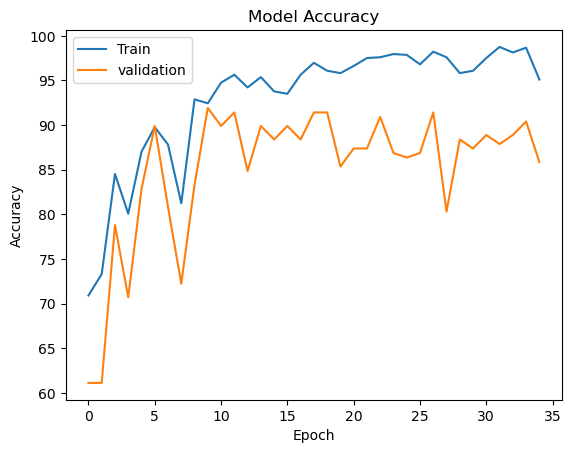

In [141]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [155]:
check_accuracy(model=model , loader= test_hrtz_dl , mode="test")

Checking accuracy on test data
Got 50 / 53 with accuracy 94.34


94.33962264150944

In [156]:
check_accuracy(model=model , loader= test_bids_dl , mode="test")

Checking accuracy on test data
Got 41 / 44 with accuracy 93.18


93.18181818181817

In [157]:
check_accuracy(model=model , loader= train_dl , mode="test")

Checking accuracy on test data
Got 1020 / 1124 with accuracy 90.75


90.74733096085409

In [158]:
check_accuracy(model=model , loader= valid_dl , mode="test")

Checking accuracy on test data
Got 182 / 198 with accuracy 91.92


91.91919191919192

In [159]:
check_accuracy(model=model , loader= valid_screen_dl , mode="test")

Checking accuracy on test data
Got 85 / 96 with accuracy 88.54


88.54166666666666

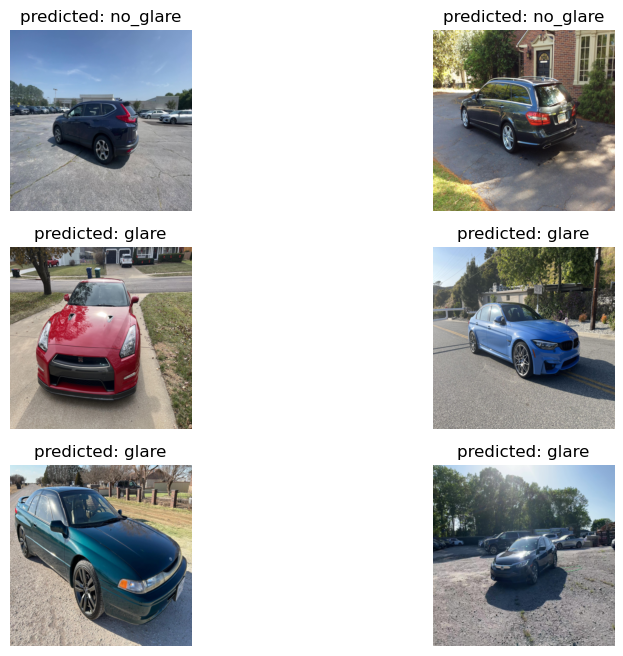

In [147]:
visualize_model(model, valid_dl, device)

## inference

<All keys matched successfully>

In [190]:
model.load_state_dict(torch.load('checkpoints/best_model_epoch_'+str(9)+'.pth'))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

def has_glare(imgAddr):
    img = Image.open(imgAddr).convert('RGB')
    # print("cccc " , img.size)
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    # print("hhh " , img.shape)
    with torch.no_grad():
        return model(img).max(1)[1]

In [192]:
has_glare("TMPimgs/03393.jpg")

tensor([1], device='cuda:0')